### Spatial transformer networks

Spatial Transformer Networks (STN) allow a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. For example, it can crop a region of interest, scale and correct the orientation of an image. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

plt.ion()

In [6]:
device = torch.device('cuda')

batch_size = 64
num_workers = 4

In [4]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                    ])
test_transform = train_transform

In [5]:
train_dataset = datasets.MNIST(root='../../data/', train=True, \
                               download=True,
                               transform=train_transform)
test_dataset = datasets.MNIST(root='../../data/', train=False, \
                              transform=test_transform)

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,\
                                          shuffle=True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,\
                                          shuffle=True, num_workers=num_workers)


In [22]:
class Model(nn.Module):
    '''
       input size: [batch_size, 1, 28, 28]
       output size: 10
    '''
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout2d = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        self.fc_loc = nn.Sequential(nn.Linear(10*3*3, 32),
                                    nn.ReLU(True),
                                    nn.Linear(32, 3*2)
                                   )
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0],
                                       dtype=torch.float))
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10*3*3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        return x
    
    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout2d(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [23]:
model = Model().to(device)

In [24]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [31]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        output = (model(data.to(device)))
        loss = F.nll_loss(output, target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print('\rEpoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')
        

In [32]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [33]:
for epoch in range(1, 21):
    train(epoch)
    test()

Epoch: 1 [29984/60000 (100%)]	Loss: 0.197237
Test set: Average loss: 0.1196, Accuracy: 9640/10000 (96%)

Epoch: 2 [29984/60000 (100%)]	Loss: 0.120211
Test set: Average loss: 0.0816, Accuracy: 9758/10000 (98%)

Epoch: 3 [29984/60000 (100%)]	Loss: 0.209964
Test set: Average loss: 0.0741, Accuracy: 9767/10000 (98%)

Epoch: 4 [29984/60000 (100%)]	Loss: 0.185781
Test set: Average loss: 0.0888, Accuracy: 9733/10000 (97%)

Epoch: 5 [29984/60000 (100%)]	Loss: 0.122788
Test set: Average loss: 0.0589, Accuracy: 9814/10000 (98%)

Epoch: 6 [29984/60000 (100%)]	Loss: 0.073888
Test set: Average loss: 0.0640, Accuracy: 9809/10000 (98%)

Epoch: 7 [29984/60000 (100%)]	Loss: 0.093446
Test set: Average loss: 0.0529, Accuracy: 9834/10000 (98%)

Epoch: 8 [29984/60000 (100%)]	Loss: 0.160644
Test set: Average loss: 0.0984, Accuracy: 9723/10000 (97%)

Epoch: 9 [29984/60000 (100%)]	Loss: 0.297575
Test set: Average loss: 0.0720, Accuracy: 9780/10000 (98%)

Epoch: 10 [29984/60000 (100%)]	Loss: 0.086764
Test set:

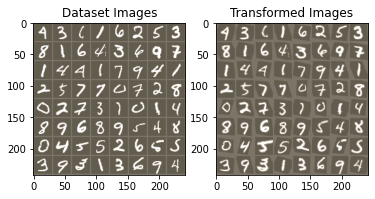

In [34]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()